# **Dataset Import, Cleaning & Merging**

Create Root Structure

In [1]:
import os

base_dir = "ds_jiji_babu"

folders = [
    base_dir,
    f"{base_dir}/csv_files",
    f"{base_dir}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Directory structure created successfully")

Directory structure created successfully


Import libraries & Load Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
trades = pd.read_csv(
    "/content/ds_jiji_babu/csv_files/historical_data.csv"
)
sentiment = pd.read_csv(
    "/content/ds_jiji_babu/csv_files/fear_greed_index.csv"
)

In [4]:
sentiment.head()
sentiment.info()

trades.head()
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

Prepare Date column

In [5]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [6]:
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
).dt.date

Select & Rename Relevant Trader Column

In [7]:
trades_clean = trades[[
    'date',
    'Closed PnL',
    'Size USD',
    'Fee'
]].copy()

In [8]:
trades_clean.rename(columns={
    'Closed PnL': 'pnl',
    'Size USD': 'volume_usd',
    'Fee': 'fee'
}, inplace=True)


Aggregate Trader Behavior (Daily)

In [9]:
daily_trades = trades_clean.groupby('date').agg(
    total_pnl=('pnl', 'sum'),
    total_volume=('volume_usd', 'sum'),
    avg_fee=('fee', 'mean'),
    trade_count=('pnl', 'count')
).reset_index()

Prepare sentiment Dataset

In [10]:
sentiment_clean = sentiment[['date', 'classification', 'value']].copy()

Merge Trader Data with sentiments

In [11]:
merged_df = pd.merge(
    daily_trades,
    sentiment_clean,
    on='date',
    how='inner'
)

Save Merged Dataset

In [12]:
merged_df.to_csv(
    "ds_jiji_babu/csv_files/merged_trader_sentiment.csv",
    index=False
)


# **Dataset Analysis and Visualizations**

Import Data

In [13]:
df = pd.read_csv(
    "/content/ds_jiji_babu/csv_files/merged_trader_sentiment.csv"
)


1. Profitability vs Market Sentiment

In [14]:
df.groupby('classification')['total_pnl'].mean()


,total_pnl
classification,
Extreme Fear,52793.589178
Extreme Greed,23817.292199
Fear,36891.818040
Greed,11140.566181
Neutral,19297.323516


<Figure size 640x480 with 0 Axes>

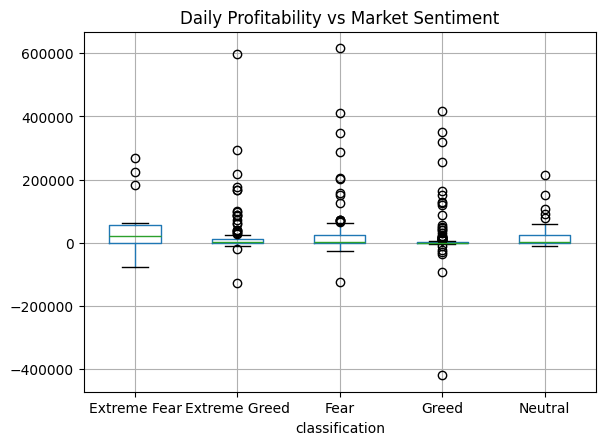

In [16]:
plt.figure()
df.boxplot(column='total_pnl', by='classification')
plt.title("Daily Profitability vs Market Sentiment")
plt.suptitle("")
plt.savefig("ds_jiji_babu/outputs/pnl_vs_sentiment.png")
plt.show()


2. Trading Volume vs Sentiment

In [17]:
df.groupby('classification')['total_volume'].mean()


,total_volume
classification,
Extreme Fear,8.177447e+06
Extreme Greed,1.091800e+06
Fear,5.311261e+06
Greed,1.495246e+06
Neutral,2.690180e+06


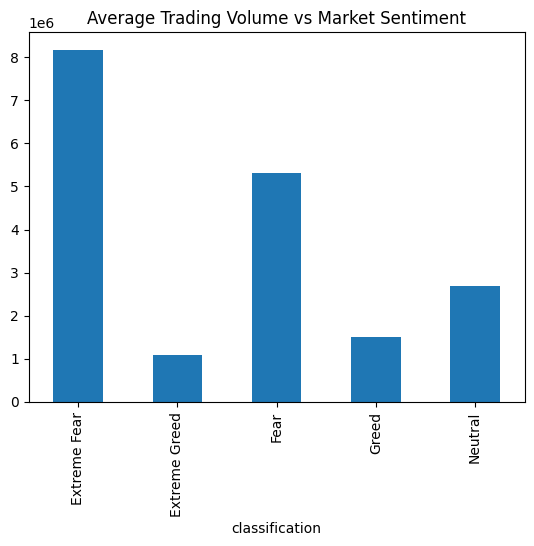

In [18]:
plt.figure()
df.groupby('classification')['total_volume'].mean().plot(kind='bar')
plt.title("Average Trading Volume vs Market Sentiment")
plt.savefig("ds_jiji_babu/outputs/volume_vs_sentiment.png")
plt.show()


3. Risk Behavior (Hidden Signal)

In [19]:
df.groupby('classification')[['trade_count', 'avg_fee']].mean()


,trade_count,avg_fee
classification,,
Extreme Fear,1528.571429,0.938658
Extreme Greed,350.807018,1.044605
Fear,679.527473,2.211484
Greed,260.637306,1.886188
Neutral,562.477612,2.279741


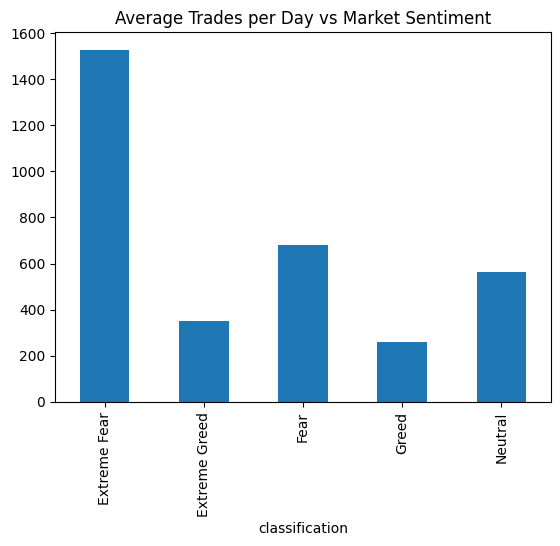

In [20]:
plt.figure()
df.groupby('classification')['trade_count'].mean().plot(kind='bar')
plt.title("Average Trades per Day vs Market Sentiment")
plt.savefig("ds_jiji_babu/outputs/trade_count_vs_sentiment.png")
plt.show()


4. Risk Adjusted Return

In [21]:
df['risk_adjusted_return'] = df['total_pnl'] / df['total_volume']

df.groupby('classification')['risk_adjusted_return'].mean()


,risk_adjusted_return
classification,
Extreme Fear,0.007883
Extreme Greed,0.021037
Fear,0.010905
Greed,0.009812
Neutral,0.008424
